In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec
from datetime import datetime


In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# check out sample
N = 1000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [5]:
df_input = pd.read_csv('data/cc_data_input_10emb_ageCat70.csv')

In [6]:
input_columns = list(df_input.columns)[1:]

In [7]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 45)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,"Age Range_(20, 25]","Age Range_(25, 30]","Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,-1.159962,1.000216,0.000130,0.000008,0.999948,0.000004,-0.000074,-3.945420e-05,-0.000120,-0.000068,-0.000049,0.000032,-0.000010,0.999873,-0.000058,-0.000095,-0.000070,-0.000075,0.000037,0.000028,0.000127,0.000073,-0.000065,-0.000106,-0.000257,-0.000085,0.000114,0.000048,-0.000007,-0.000005,0.000019,0.000026,-0.000031,-0.000020,0.000019,1.608610,-4.304867,-0.356749,1.443709,-1.034268,0.489669,-1.827377,-3.538892,-3.831318,1.759107
1,15.022159,0.999980,0.000030,0.999862,0.000037,0.000087,-0.000096,-5.627095e-08,-0.000033,-0.000044,-0.000030,1.000256,-0.000014,0.000014,0.000018,0.000091,-0.000061,-0.000047,-0.000077,0.000049,-0.000027,0.000042,0.000007,-0.000033,-0.000029,0.000025,-0.000126,-0.000039,-0.000009,-0.000098,-0.000015,0.000056,0.000084,0.000078,-0.000037,0.753421,-0.741460,0.319349,-0.193131,1.489730,-2.787934,-0.573041,-2.122181,0.106104,-1.513622
2,6.017153,1.000014,0.000238,0.999986,0.000010,-0.000034,0.000026,-7.355010e-05,0.999564,-0.000021,0.000041,-0.000031,0.000046,-0.000097,-0.000012,0.000115,0.000008,-0.000143,0.000051,0.000002,0.000018,0.000078,-0.000063,-0.000106,0.000011,0.000032,0.000019,0.000068,0.000067,-0.000029,0.000073,-0.000008,0.000077,-0.000063,0.000005,-0.211521,-1.336909,0.405988,0.943252,-0.628795,0.206525,-0.856393,-0.632848,-0.473376,0.495889
3,7.749006,0.000071,0.999925,1.000006,0.000125,0.000043,-0.000052,2.790605e-05,-0.000029,0.000041,-0.000038,1.000051,-0.000030,0.000065,0.000011,0.000033,0.000048,-0.000031,-0.000024,0.000014,0.000054,0.000014,0.000135,-0.000051,0.000130,0.000041,0.000121,0.000036,0.000006,-0.000052,-0.000055,-0.000070,0.000096,0.000048,-0.000019,-0.252419,-1.711572,-0.636657,0.474073,0.306593,-2.970573,-0.854668,-0.533544,-0.135051,0.841356
4,10.575532,0.999901,0.000166,0.999895,0.000010,-0.000120,0.000010,1.814428e-06,0.999981,0.000077,0.000044,0.999994,-0.000043,0.000002,0.000006,0.000012,0.000054,0.000075,0.000072,0.000115,0.000034,0.000031,-0.000212,-0.000105,-0.000021,0.000028,-0.000123,0.000026,0.000012,0.000024,0.000081,0.000014,-0.000040,-0.000075,0.000037,1.007865,-1.269549,0.624097,0.317919,0.133508,-2.343635,-1.430025,-0.564173,-0.830563,-0.778737


In [8]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for absolute max in each row and put into one series
    df_output = pd.Series(tmp.abs().idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [9]:
#df_purchase = df_sample.iloc[:,[0,1]]
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [10]:
#df_reverse = pd.concat([df_purchase,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(1000, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,-1.159962,"(25, 30]",bank_account,male,Other,Tuesday,start
1,15.022159,"(25, 30]",bank_account,female,Grocery Stores,Friday,mid
2,6.017153,"(55, 60]",bank_account,female,Eating Places,Saturday,mid
3,7.749006,"(25, 30]",credit_card,female,Grocery Stores,Tuesday,end
4,10.575532,"(25, 30]",bank_account,female,Grocery Stores,Thursday,end


In [11]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [12]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,-1.159962,"(25, 30]",bank_account,male,Other,Tuesday,start,30
1,15.022159,"(25, 30]",bank_account,female,Grocery Stores,Friday,mid,30
2,6.017153,"(55, 60]",bank_account,female,Eating Places,Saturday,mid,60
3,7.749006,"(25, 30]",credit_card,female,Grocery Stores,Tuesday,end,27
4,10.575532,"(25, 30]",bank_account,female,Grocery Stores,Thursday,end,28


In [13]:
#df_reverse['SIC Description'].value_counts()[:9].index.tolist()

In [14]:
##retailer_map_grouped
#for i in range(0,100):
#    word_list = retailer_map_grouped[df_SIC_vector['SIC Description'][i]]
#    print(df_SIC_vector['SIC Description'][i])
#    min_idx = model.wv.distances(df_SIC_vector['retailerVec'][i], other_words = word_list).argmin()
#    print(word_list[min_idx])
#    print('\n')

In [16]:
# load the retailer_map
with open('models/retailer_map_grouped.pkl', 'rb') as input:
    retailer_map_grouped = pickle.load(input)  

In [36]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]  

# put retailer vectors into one column
df_retailerVec['retailerVec'] = df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_reverse['SIC Description'], df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SIC Description,retailerVec
0,Grocery Stores,"[1.6086102586371318, -4.304866563350703, -0.35..."
1,Eating Places,"[0.7534209465488944, -0.7414602909860176, 0.31..."
2,Grocery Stores,"[-0.21152105940923926, -1.3369094599293254, 0...."
3,Grocery Stores,"[-0.25241933007424333, -1.7115723441259674, -0..."
4,Eating Places,"[1.0078654244661176, -1.2695489593515288, 0.62..."


In [18]:
retailer_map_grouped.keys()
#retailer_map_grouped['Gasoline Service Stations']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [19]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [20]:
model = Word2Vec.load('models/retailer_embedding.model')
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head(10)

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,-1.159962,"(25, 30]",bank_account,male,Other,Tuesday,start,30,Laura Secord
1,15.022159,"(25, 30]",bank_account,female,Grocery Stores,Friday,mid,30,99 Cents Only Stores
2,6.017153,"(55, 60]",bank_account,female,Eating Places,Saturday,mid,60,Tim Hortons
3,7.749006,"(25, 30]",credit_card,female,Grocery Stores,Tuesday,end,27,Ruth's
4,10.575532,"(25, 30]",bank_account,female,Grocery Stores,Thursday,end,28,S Mart
5,12.726457,"(50, 55]",credit_card,male,Eating Places,Monday,end,54,Aramark
6,6.079677,"(55, 60]",credit_card,male,Grocery Stores,Monday,mid,60,Bangkok Groceries
7,20.948943,"(20, 25]",bank_account,male,Other,Saturday,start,25,Princess
8,3.702412,"(35, 40]",credit_card,male,Other,Wednesday,end,37,Hudson's Bay
9,57.591957,"(60, 65]",credit_card,male,"Communications Services, Not Elsewhere Classified",Thursday,end,63,Vimeo


In [21]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [22]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,-1.159962,"(25, 30]",bank_account,male,Other,Tuesday,start,30,Laura Secord,2022-02-01
1,15.022159,"(25, 30]",bank_account,female,Grocery Stores,Friday,mid,30,99 Cents Only Stores,2022-02-11
2,6.017153,"(55, 60]",bank_account,female,Eating Places,Saturday,mid,60,Tim Hortons,2022-02-19
3,7.749006,"(25, 30]",credit_card,female,Grocery Stores,Tuesday,end,27,Ruth's,2022-02-22
4,10.575532,"(25, 30]",bank_account,female,Grocery Stores,Thursday,end,28,S Mart,2022-02-24


In [23]:
print(df_reverse['day_of_week'].value_counts())
print(df_reverse['period_of_month'].value_counts())

Thursday     172
Friday       169
Tuesday      143
Monday       139
Saturday     137
Wednesday    136
Sunday       104
Name: day_of_week, dtype: int64
end      341
start    332
mid      327
Name: period_of_month, dtype: int64


In [24]:
# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

# load processed input data to check mean purchase amount for each retailer
df_processed = pd.read_csv('data/cc_data_processed.csv')
df_processed.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [25]:
#df_processed_G = df_processed.groupby('Normalized Retailer').agg({'Purchase Amount': {'size', 'mean'}})
#df_processed_G.sort_values([('Purchase Amount','size')], ascending=False)

In [26]:
# create columns that are mean_byRetailer_input, mean_byRetailer_syn, and apply their ratio to adjust Purchase Amount
df_reverse['mean_byRetailer_syn'] = df_reverse['Normalized Retailer'].map(df_reverse.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['mean_byRetailer_input'] = df_reverse['Normalized Retailer'].map(df_processed.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['Purchase Amount Corrected'] = df_reverse.apply(lambda x: x['Purchase Amount'] * x.mean_byRetailer_input / x.mean_byRetailer_syn, axis = 1)

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date,mean_byRetailer_syn,mean_byRetailer_input,Purchase Amount Corrected
0,15.022159,"(25, 30]",bank_account,female,Grocery Stores,Friday,mid,30,99 Cents Only Stores,2022-02-11,42.590508,12.078750,4.260313
1,6.017153,"(55, 60]",bank_account,female,Eating Places,Saturday,mid,60,Tim Hortons,2022-02-19,6.187280,6.093320,5.925777
2,7.749006,"(25, 30]",credit_card,female,Grocery Stores,Tuesday,end,27,Ruth's,2022-02-22,7.749006,61.007755,61.007755
3,10.575532,"(25, 30]",bank_account,female,Grocery Stores,Thursday,end,28,S Mart,2022-02-24,17.465758,87.131342,52.758104
4,12.726457,"(50, 55]",credit_card,male,Eating Places,Monday,end,54,Aramark,2022-02-21,8.134036,14.351389,22.454086


In [37]:
# drop intermediate values
col2drop = ['Age Range','day_of_week','period_of_month','mean_byRetailer_syn','mean_byRetailer_input']
df_reverse.drop(col2drop, axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Account Type,Consumer Gender,SIC Description,Age,Normalized Retailer,Transaction Date,Purchase Amount Corrected
0,15.022159,bank_account,female,Grocery Stores,30,99 Cents Only Stores,2022-02-11,4.260313
1,6.017153,bank_account,female,Eating Places,60,Tim Hortons,2022-02-19,5.925777
2,7.749006,credit_card,female,Grocery Stores,27,Ruth's,2022-02-22,61.007755
3,10.575532,bank_account,female,Grocery Stores,28,S Mart,2022-02-24,52.758104
4,12.726457,credit_card,male,Eating Places,54,Aramark,2022-02-21,22.454086


In [50]:
# save synthesized data into csv file
#output_filename = str(Y) + '_' + datetime.strptime(str(M), "%m").strftime("%b") + '.csv'
#df_reverse.to_csv('output/' + output_filename)

2022_Feb.csv


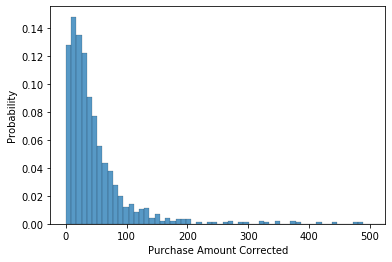

In [27]:
#sns.histplot(df_reverse['Purchase Amount'], stat="probability");
sns.histplot(df_reverse['Purchase Amount Corrected'], stat="probability");
plt.xlim(-25, 525);

#plt.savefig('figs/eda/purchase_hist_syn_ageCat70_corr.png',bbox_inches='tight')

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


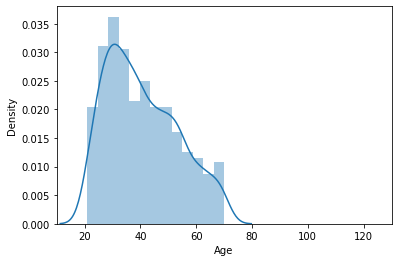

In [28]:
sns.distplot(df_reverse['Age']);
plt.xlim(10, 130);
#plt.savefig('figs/eda/age_hist_syn_ageCat70_0.5M.png',bbox_inches='tight')

In [29]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [30]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account     564  57.905544
1   credit_card     410  42.094456


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female     542  55.646817
1            male     432  44.353183


Normalized Retailer
       Normalized Retailer  Counts   Per (%)
345            Tim Hortons      56  5.749487
240           Petro-Canada      32  3.285421
366                Walmart      31  3.182752
295                  Shell      17  1.745380
6                   Amazon      16  1.642710
..                     ...     ...       ...
246            Pizza Depot       1  0.102669
247          Pizza Express       1  0.102669
51            China Garden       1  0.102669
250               Pizzaway       1  0.102669
59   Commissos Fresh Foods       1  0.102669

[387 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Eating Places     291  29.876797
6    

barplot for SIC Description


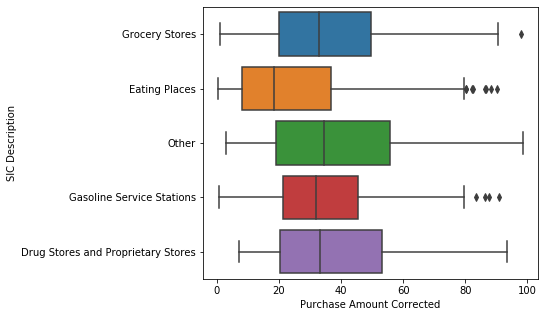

barplot for Normalized Retailer


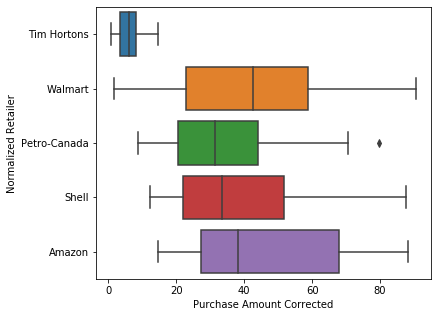

In [31]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount Corrected'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount Corrected'])
    plt.show()